In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.metrics import mean_absolute_error
import itertools
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
df = pd.read_csv('DF_FINAL.csv')
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])
df

Territory_code Plant_code Brand_code  Package Week_End_Date  \
0                  A          a         AC   TP 0.2    2023-01-06   
1                  A          a         AC   TP 0.2    2023-01-13   
2                  A          a         AC   TP 0.2    2023-01-20   
3                  A          a         AC   TP 0.2    2023-01-27   
4                  A          a         AC   TP 0.2    2023-02-03   
...              ...        ...        ...      ...           ...   
58305              I         an         AD  PET 1.0    2024-11-29   
58306              I         an         AD  PET 1.0    2024-12-06   
58307              I         an         AD  PET 1.0    2024-12-13   
58308              I         an         AD  PET 1.0    2024-12-20   
58309              I         an         AD  PET 1.0    2024-12-27   

       Sum of Plan        fact           row_id  
0         1.000000    0.010000    A_a_AC_TP 0.2  
1         1.000000    4.010000    A_a_AC_TP 0.2  
2        61.000000    6.010000    A_a_AC_TP 0.2  
3         0.000000    8.010000    A_a_AC_TP 0.2  
4        18.879000    9.520000    A_a_AC_TP 0.2  
...            ...         ...              ...  
58305    54.766687   78.192999  I_an_AD_PET 1.0  
58306    65.133425  171.193998  I_an_AD_PET 1.0  
58307    59.458602   46.503001  I_an_AD_PET 1.0  
58308    77.697035    8.463000  I_an_AD_PET 1.0  
58309    38.618049    0.010000  I_an_AD_PET 1.0  

[58310 rows x 8 columns]

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
# --- –ú–µ—Ç—Ä–∏–∫–∏ ---
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.where(denom == 0, 1, denom)) * 100

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

In [5]:
# –ü–æ–¥–≥–æ–Ω–∫–∞ –æ–¥–Ω–æ–π –º–æ–¥–µ–ª–∏
def evaluate_sarima(y_train, y_val, order, seasonal):
    try:
        model = SARIMAX(
            y_train,
            order=order,
            seasonal_order=(seasonal[0], seasonal[1], seasonal[2], seasonal[3]),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        pred_val = results.forecast(steps=len(y_val))
        mae = mean_absolute_error(y_val, pred_val)
        return (mae, order, seasonal, results)
    except:
        return (np.inf, order, seasonal, None)

In [6]:
# –û—Å–Ω–æ–≤–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è
def fit_sarima_for_row(df, row_id):
    ts = df[df['row_id'] == row_id].copy()
    ts = ts.sort_values('Week_End_Date')
    ts.set_index('Week_End_Date', inplace=True)

    y = ts['fact']
    n = len(y)
    train_end = int(n * 0.9)
    val_end = int(n * 0.95)

    y_train = y.iloc[:train_end]
    y_val = y.iloc[train_end:val_end]
    y_test = y.iloc[val_end:]

    results = Parallel(n_jobs=-1)(
        delayed(evaluate_sarima)(y_train, y_val, order, seasonal)
        for order in pdq for seasonal in seasonal_pdq
    )

    best_result = min(results, key=lambda x: x[0])
    best_mae, best_order, best_seasonal_order, _ = best_result

    # –§–∏–Ω–∞–ª—å–Ω–∞—è –º–æ–¥–µ–ª—å –Ω–∞ train + val
    model_final = SARIMAX(
        y.iloc[:val_end],
        order=best_order,
        seasonal_order=best_seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results_final = model_final.fit(disp=False)
    forecast = results_final.forecast(steps=len(y_test))
    forecast = np.clip(forecast, 0, None)

    # –ú–µ—Ç—Ä–∏–∫–∏
    mae_test = mean_absolute_error(y_test, forecast)
    wape_test = wape(y_test.values, forecast.values)
    smape_test = smape(y_test.values, forecast.values)

    return {
        'row_id': row_id,
        'best_order': best_order,
        'best_seasonal_order': best_seasonal_order,
        'mae': mae_test,
        'wape': wape_test,
        'smape': smape_test,
        'actual': y_test,
        'forecast': forecast
    }

In [7]:
def fit_sarima_for_row(df, row_id):
    ts = df[df['row_id'] == row_id].copy()
    ts = ts.sort_values('Week_End_Date')
    ts.set_index('Week_End_Date', inplace=True)

    y = ts['fact']
    n = len(y)
    train_end = int(n * 0.9)
    val_end = int(n * 0.95)

    y_train = y.iloc[:train_end]
    y_val = y.iloc[train_end:val_end]
    y_test = y.iloc[val_end:]

    best_mae = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    for order in pdq:
        for seasonal in seasonal_pdq:
            try:
                model = SARIMAX(
                    y_train,
                    order=order,
                    seasonal_order=(seasonal[0], seasonal[1], seasonal[2], seasonal[3]),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                pred_val = results.forecast(steps=len(y_val))
                mae = mean_absolute_error(y_val, pred_val)

                if mae < best_mae:
                    best_mae = mae
                    best_order = order
                    best_seasonal_order = seasonal
                    best_model = results

            except:
                continue

    if best_model is None:
        return None

    model_final = SARIMAX(
        y.iloc[:val_end],
        order=best_order,
        seasonal_order=best_seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results_final = model_final.fit(disp=False)
    forecast = results_final.forecast(steps=len(y_test))
    forecast = np.clip(forecast, 0, None)

    return {
        'row_id': row_id,
        'best_order': best_order,
        'best_seasonal_order': best_seasonal_order,
        'mae': mean_absolute_error(y_test, forecast),
        'wape': wape(y_test.values, forecast.values),
        'smape': smape(y_test.values, forecast.values),
        'actual': y_test,
        'forecast': forecast
    }

In [8]:
p = q = range(0, 2)             
P = Q = range(0, 2)             
d = [0,1]
D = [0,1]
s_values = [12]                 

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s_values))

In [9]:
result = fit_sarima_for_row(df, 'A_a_AD_PET 1.0')
print(result)

F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No 

{'row_id': 'A_a_AD_PET 1.0', 'best_order': (0, 0, 1), 'best_seasonal_order': (1, 1, 1, 12), 'mae': 49.20641038756357, 'wape': np.float64(54.352906032734474), 'smape': np.float64(94.16896808869696), 'actual': Week_End_Date
2024-11-22     73.974998
2024-11-29    103.561001
2024-12-06      0.010000
2024-12-13    169.080002
2024-12-20    164.851998
2024-12-27     31.710000
Name: fact, dtype: float64, 'forecast': 2024-11-22    101.111858
2024-11-29     84.084856
2024-12-06     67.189678
2024-12-13     92.972516
2024-12-20     91.026478
2024-12-27      0.197226
Freq: W-FRI, Name: predicted_mean, dtype: float64}


F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
def plot_forecast_full_history(df, result_dict):
    row_id = result_dict['row_id']
    best_order = result_dict['best_order']
    best_seasonal_order = result_dict['best_seasonal_order']
    smape_score = result_dict['smape']
    
    ts = df[df['row_id'] == row_id].copy()
    ts = ts.sort_values('Week_End_Date')
    ts.set_index('Week_End_Date', inplace=True)
    
    full_y = ts['fact']
    forecast = result_dict['forecast']
    actual = result_dict['actual']
    
    # –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ
    plt.figure(figsize=(14, 6))
    plt.plot(full_y.index, full_y.values, label='Actual', marker='o')
    plt.plot(actual.index, forecast.values, label='Forecast', marker='x', linestyle='--')
    
    title = (
        f"{row_id} | SMAPE: {smape_score:.2f}%\n"
        f"Best SARIMA{best_order} x {best_seasonal_order}"
    )
    plt.title(title)
    plt.xlabel("Week_End_Date")
    plt.ylabel("fact")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

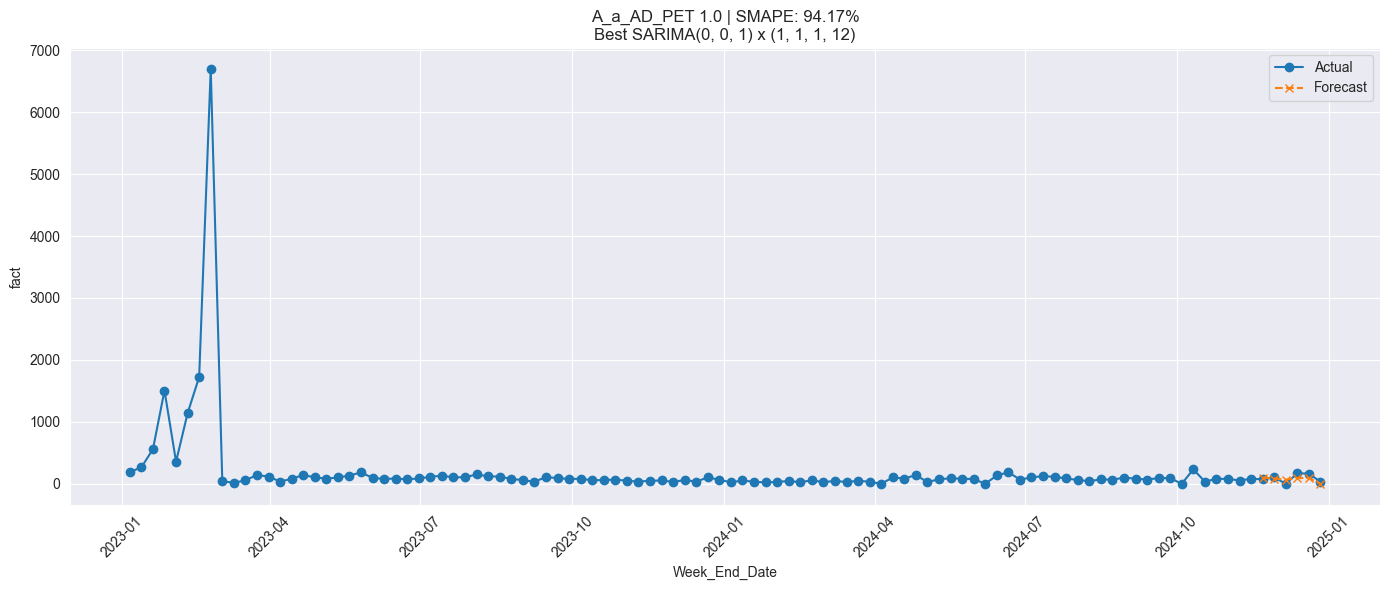

In [11]:
plot_forecast_full_history(df, result)

–î–ª—è –≤—Å–µ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [12]:
def fit_all_series(df):
    results = []
    unique_ids = df['row_id'].unique()

    for row_id in tqdm(unique_ids, desc="–û–±—Ä–∞–±–æ—Ç–∫–∞ —Ä—è–¥–æ–≤"):
        try:
            result = fit_sarima_for_row(df, row_id)
            results.append(result)
        except Exception as e:
            print(f"–û—à–∏–±–∫–∞ –Ω–∞ {row_id}: {e}")
            continue

    return results

In [13]:
def fit_all_series_parallel(df, n_jobs=-1):
    unique_ids = df['row_id'].unique()

    results = Parallel(n_jobs=n_jobs)(
        delayed(fit_sarima_for_row)(df, row_id) for row_id in tqdm(unique_ids, desc="–û–±—Ä–∞–±–æ—Ç–∫–∞ —Ä—è–¥–æ–≤")
    )

    return [r for r in results if r is not None]

In [14]:
all_results = fit_all_series_parallel(df, n_jobs=-1)

–û–±—Ä–∞–±–æ—Ç–∫–∞ —Ä—è–¥–æ–≤: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 602/602 [08:07<00:00,  1.24it/s]


In [15]:
metrics_df = pd.DataFrame([{
    'row_id': r['row_id'],
    'mae': r['mae'],
    'wape': r['wape'],
    'smape': r['smape'],
    'order': r['best_order'],
    'seasonal_order': r['best_seasonal_order']
} for r in all_results])
metrics_df

row_id         mae        wape       smape      order  \
0      A_a_AC_TP 0.2    1.453920   65.227471  123.147706  (0, 0, 1)   
1      A_a_AC_TP 1.0   87.358193   99.999649  199.750490  (1, 0, 0)   
2     A_a_AD_PET 1.0   49.206410   54.352906   94.168968  (0, 0, 1)   
3     A_b_AA_PET 0.5   82.096058  136.275602  153.837925  (1, 1, 0)   
4     A_b_AA_PET 1.0   32.209383  157.585294  164.790368  (1, 0, 0)   
..               ...         ...         ...         ...        ...   
597  I_am_AH_PET 1.0  179.625707   99.997704  147.358455  (1, 0, 0)   
598  I_am_AJ_PET 1.0   75.543750   85.619689  137.346382  (0, 1, 0)   
599  I_an_AC_PET 0.3    6.511544  109.856207  186.109558  (1, 0, 1)   
600   I_an_AC_TP 2.0  177.242513   99.048137  163.770195  (1, 0, 0)   
601  I_an_AD_PET 1.0   64.454500   99.984488  166.553146  (0, 1, 0)   

    seasonal_order  
0    (0, 0, 1, 12)  
1    (0, 0, 0, 12)  
2    (1, 1, 1, 12)  
3    (1, 1, 1, 12)  
4    (1, 0, 0, 12)  
..             ...  
597  (0, 0, 0, 12)  
598  (0, 0, 0, 12)  
599  (0, 0, 0, 12)  
600  (1, 0, 0, 12)  
601  (0, 0, 0, 12)  

[602 rows x 6 columns]

In [16]:
metrics_df[['wape', 'smape']].describe()

wape       smape
count    602.000000  602.000000
mean     401.987388  105.398376
std     3393.171140   49.467865
min        9.756035    5.398014
25%       66.932090   66.663823
50%       96.685685   98.649359
75%      107.322078  139.632812
max    64014.839591  200.000000

In [29]:
metrics_df['WAPE_clipped'] = metrics_df['wape'].clip(upper=300)
metrics_df[['wape', 'smape', 'WAPE_clipped']].describe()

wape       smape  WAPE_clipped
count    602.000000  602.000000    602.000000
mean     401.987388  105.398376    102.741376
std     3393.171140   49.467865     60.576120
min        9.756035    5.398014      9.756035
25%       66.932090   66.663823     66.932090
50%       96.685685   98.649359     96.685685
75%      107.322078  139.632812    107.322078
max    64014.839591  200.000000    300.000000

In [25]:
def plot_fact_vs_forecast_full(df, all_results, target_row_ids):
    for row_id in target_row_ids:
        row_data = next((r for r in all_results if r['row_id'] == row_id), None)
        if row_data is None:
            print(f"‚ö†Ô∏è –ü—Ä–æ–≥–Ω–æ–∑ –¥–ª—è {row_id} –Ω–µ –Ω–∞–π–¥–µ–Ω.")
            continue

        # –ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è
        y_full = df[df['row_id'] == row_id].sort_values('Week_End_Date')
        y_full.set_index('Week_End_Date', inplace=True)

        # –û–±—ä–µ–¥–∏–Ω—è–µ–º actual –∏ forecast
        y_actual = row_data['actual']
        y_forecast = row_data['forecast']

        plt.figure(figsize=(12, 4))
        plt.plot(y_full.index, y_full['fact'], label='Actual', marker='o', alpha=0.6)
        plt.plot(y_forecast.index, y_forecast.values, label='Forecast', marker='x', linestyle='--')
        plt.title(f"{row_id} | SMAPE: {row_data['smape']:.2f}%")
        plt.xlabel("Week_End_Date")
        plt.ylabel("fact")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

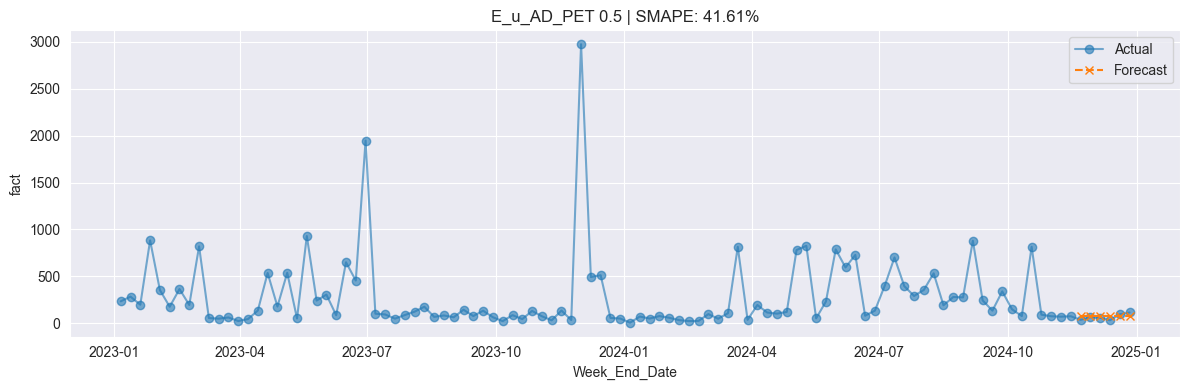

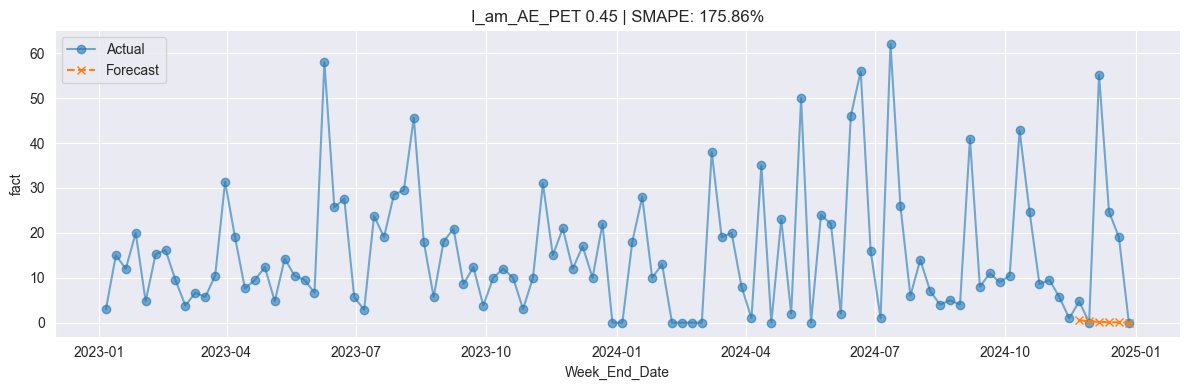

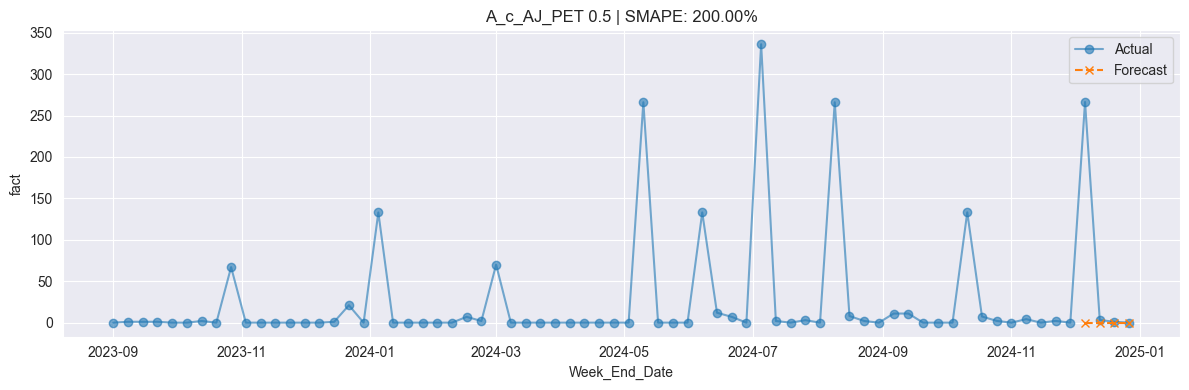

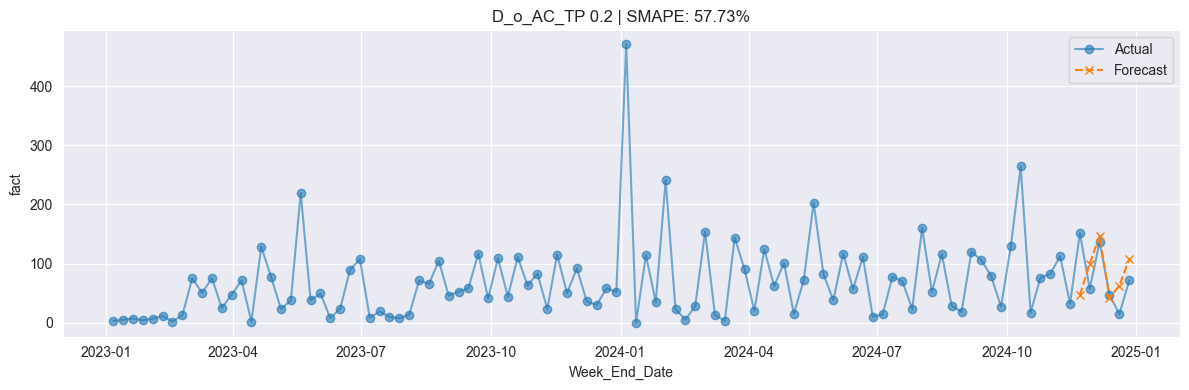

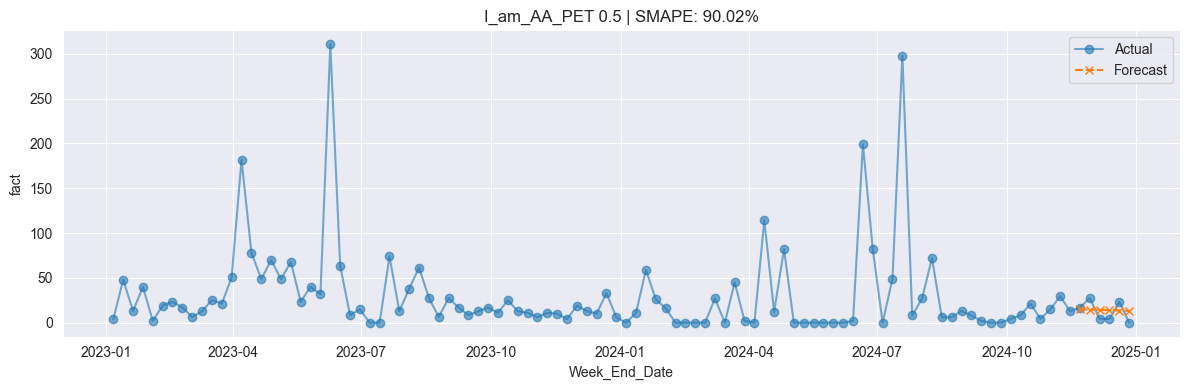

In [26]:
target_ids = [
  'E_u_AD_PET 0.5',
  'I_am_AE_PET 0.45',
  'A_c_AJ_PET 0.5',
  'D_o_AC_TP 0.2',
  'I_am_AA_PET 0.5'
]

plot_fact_vs_forecast_full(df, all_results, target_ids)

In [27]:
# –§–∏–ª—å—Ç—Ä—É–µ–º –∏ —Å–æ–±–∏—Ä–∞–µ–º –º–µ—Ç—Ä–∏–∫–∏
metrics_summary = []

for row_id in target_ids:
    r = next((x for x in all_results if x['row_id'] == row_id), None)
    if r:
        metrics_summary.append({
            'row_id': row_id,
            'mae': round(r.get('mae', float('nan')), 2),
            'wape': round(r.get('wape', float('nan')), 2),
            'smape': round(r.get('smape', float('nan')), 2),
        })
    else:
        metrics_summary.append({
            'row_id': row_id,
            'mae': 'N/A',
            'wape': 'N/A',
            'smape': 'N/A',
        })

# –°–æ–∑–¥–∞—ë–º DataFrame
metrics_df_subset = pd.DataFrame(metrics_summary)
metrics_df_subset

row_id    mae    wape   smape
0    E_u_AD_PET 0.5  28.18   41.23   41.61
1  I_am_AE_PET 0.45  17.19   99.43  175.86
2    A_c_AJ_PET 0.5  67.64  100.00  200.00
3     D_o_AC_TP 0.2  41.24   51.72   57.73
4   I_am_AA_PET 0.5   9.56   75.33   90.02

In [21]:
from statsmodels.tsa.stattools import acf
from collections import Counter
from statsmodels.tsa.seasonal import STL

In [18]:
def estimate_s_from_acf(y, max_lag=60, threshold=0.3):
    try:
        acf_vals = acf(y, nlags=max_lag, fft=True)
        # –ò–≥–Ω–æ—Ä–∏—Ä—É–µ–º –ª–∞–≥ 0
        lags = np.arange(1, len(acf_vals))
        # –í—ã–±–∏—Ä–∞–µ–º –ª–∞–≥–∏ —Å –∞–≤—Ç–æ–∫–æ—Ä—Ä–µ–ª—è—Ü–∏–µ–π –≤—ã—à–µ –ø–æ—Ä–æ–≥–∞
        strong_lags = lags[acf_vals[1:] > threshold]
        return int(strong_lags[0]) if len(strong_lags) > 0 else None
    except:
        return None

In [19]:
# --- –û—Å–Ω–æ–≤–Ω–æ–π —Ü–∏–∫–ª –ø–æ –≤—Å–µ–º —Ä—è–¥–∞–º ---
s_guesses = []

for row_id in tqdm(df['row_id'].unique(), desc="–ê–Ω–∞–ª–∏–∑ —Å–µ–∑–æ–Ω–Ω–æ—Å—Ç–∏ (ACF)"):
    y = df[df['row_id'] == row_id].sort_values('Week_End_Date')['fact']
    if len(y) < 30:
        continue  # —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–µ —Ä—è–¥—ã –ø—Ä–æ–ø—É—Å–∫–∞–µ–º
    s = estimate_s_from_acf(y)
    if s is not None:
        s_guesses.append(s)

# --- –ê–Ω–∞–ª–∏–∑ —á–∞—Å—Ç–æ—Ç—ã ---
counter = Counter(s_guesses)
print("\n –¢–æ–ø –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö —Å–µ–∑–æ–Ω–Ω—ã—Ö –ª–∞–≥–æ–≤:")
for s_val, count in counter.most_common(10):
    print(f"s = {s_val}: {count} —Ä—è–¥–æ–≤")

–ê–Ω–∞–ª–∏–∑ —Å–µ–∑–æ–Ω–Ω–æ—Å—Ç–∏ (ACF): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 602/602 [00:02<00:00, 288.22it/s]


üéØ –¢–æ–ø –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö —Å–µ–∑–æ–Ω–Ω—ã—Ö –ª–∞–≥–æ–≤:
s = 1: 99 —Ä—è–¥–æ–≤
s = 4: 15 —Ä—è–¥–æ–≤
s = 2: 11 —Ä—è–¥–æ–≤
s = 13: 7 —Ä—è–¥–æ–≤
s = 6: 7 —Ä—è–¥–æ–≤
s = 22: 6 —Ä—è–¥–æ–≤
s = 9: 4 —Ä—è–¥–æ–≤
s = 3: 4 —Ä—è–¥–æ–≤
s = 18: 3 —Ä—è–¥–æ–≤
s = 16: 3 —Ä—è–¥–æ–≤


In [20]:
# –¢–æ–ø-3 –ª—É—á—à–∏—Ö –ø–æ smape (–Ω–∏–∑–∫–∏–π SMAPE)
best_ids = metrics_df.nsmallest(3, 'smape')['row_id'].tolist()

# –¢–æ–ø-3 —Ö—É–¥—à–∏—Ö –ø–æ smape (–≤—ã—Å–æ–∫–∏–π SMAPE)
worst_ids = metrics_df.nlargest(3, 'smape')['row_id'].tolist()

# 2 —Å–ª—É—á–∞–π–Ω—ã—Ö
random_ids = metrics_df.sample(2, random_state=42)['row_id'].tolist()

# –ò—Ç–æ–≥–æ–≤–∞—è –≤—ã–±–æ—Ä–∫–∞
selected_ids = best_ids + worst_ids + random_ids
print("–í—ã–±—Ä–∞–Ω–Ω—ã–µ —Ä—è–¥—ã –¥–ª—è STL:", selected_ids)

–í—ã–±—Ä–∞–Ω–Ω—ã–µ —Ä—è–¥—ã –¥–ª—è STL: ['C_ao_AJ_PET 1.0', 'G_ae_AD_PET 0.3', 'B_k_AH_PET 1.0', 'A_c_AA_PET 1.0', 'A_c_AJ_PET 0.5', 'A_c_AJ_PET 1.0', 'B_h_AD_CAN 0.33', 'G_aa_AJ_PET 0.5']


In [22]:
def plot_stl_decomposition(df, row_id, s):
    ts = df[df['row_id'] == row_id].copy()
    ts = ts.sort_values('Week_End_Date')
    ts.set_index('Week_End_Date', inplace=True)
    
    y = ts['fact']
    if len(y) < s * 2:
        print(f"‚ùå –†—è–¥ {row_id} —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–π –¥–ª—è STL —Å period={s}")
        return

    stl = STL(y, period=s, robust=True)
    result = stl.fit()

    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
    result.plot()
    plt.suptitle(f"STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è: row_id = {row_id}, period = {s}", fontsize=14)
    plt.tight_layout()
    plt.show()


üîç STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –¥–ª—è: C_ao_AJ_PET 1.0


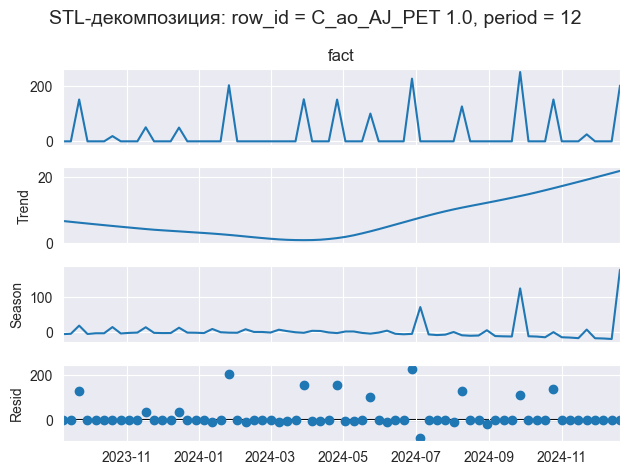


üîç STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –¥–ª—è: G_ae_AD_PET 0.3


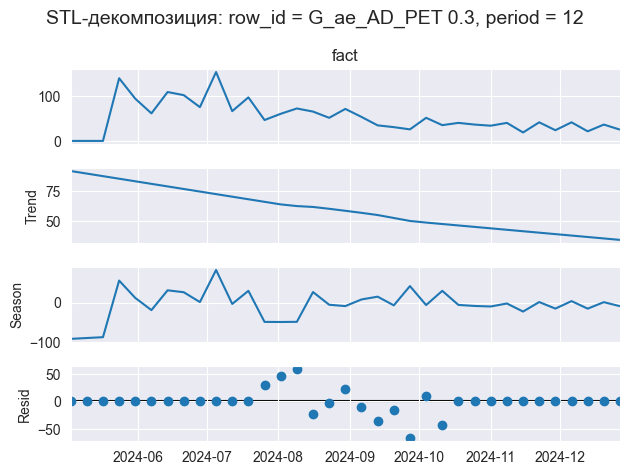


üîç STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –¥–ª—è: B_k_AH_PET 1.0


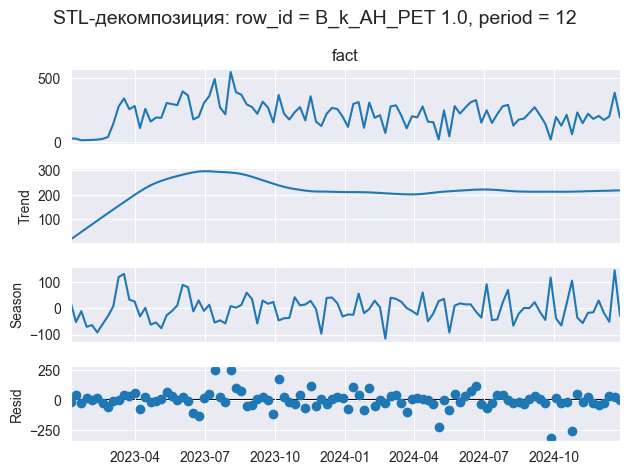


üîç STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –¥–ª—è: A_c_AA_PET 1.0


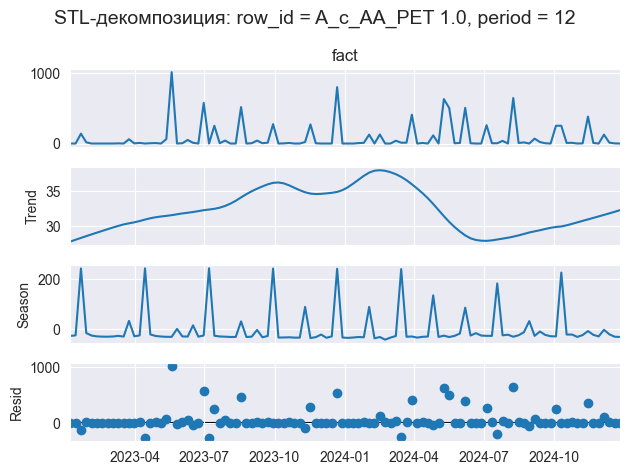


üîç STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –¥–ª—è: A_c_AJ_PET 0.5


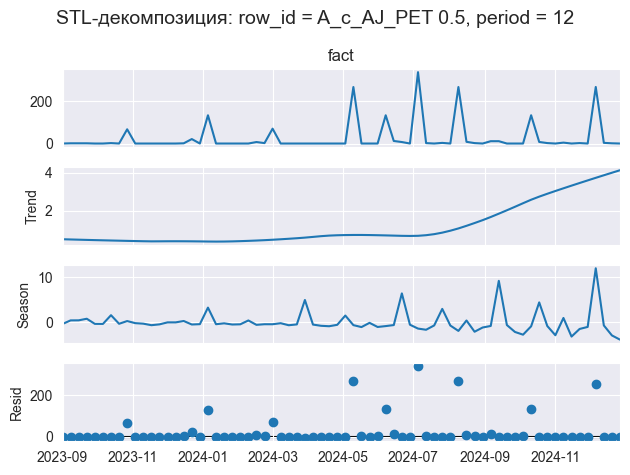


üîç STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –¥–ª—è: A_c_AJ_PET 1.0


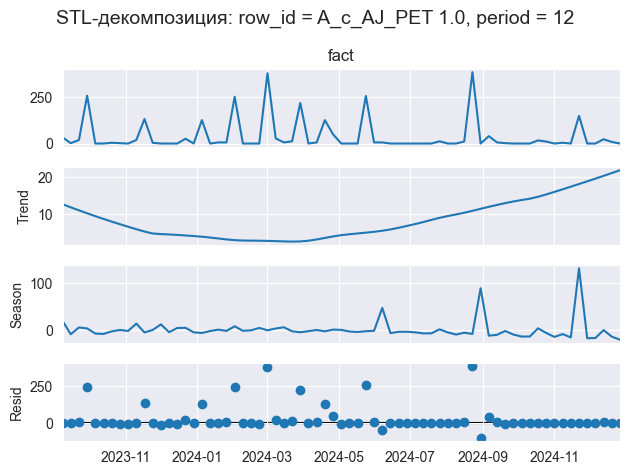


üîç STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –¥–ª—è: B_h_AD_CAN 0.33


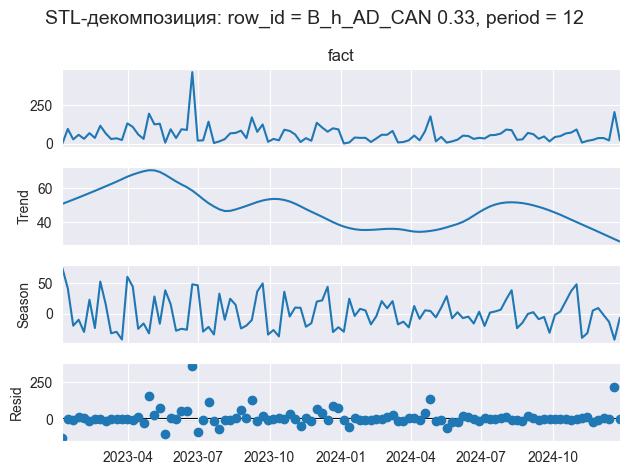


üîç STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –¥–ª—è: G_aa_AJ_PET 0.5


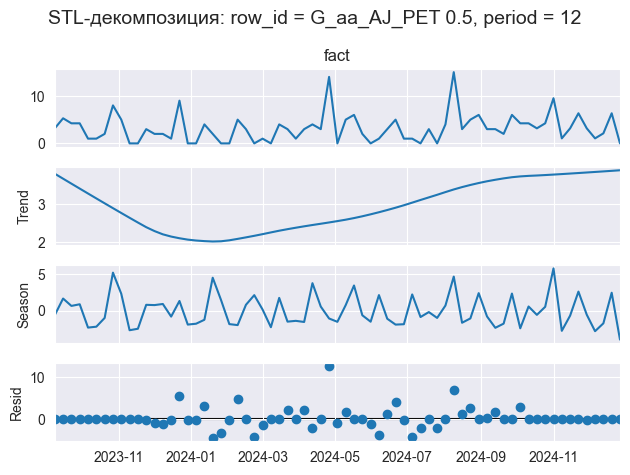

In [24]:
for row in selected_ids:
    print(f"\nüîç STL-–¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –¥–ª—è: {row}")
    plot_stl_decomposition(df, row_id=row, s=12)